<h1>Intro</h1>
<ul>
    <li>It's noy a guide how to make a real model for trading</li>
    <li>The main purpose of this notebook is to show how to work with time series in order to use Gradient Boosting</li>
    <li>The dataset is downloaded form kaggle <a href='https://www.kaggle.com/mczielinski/bitcoin-historical-data'>Bitcoin Historical Data</a></li>
    <li>As i don't have enough memory I'll try to solve the task predicting the next 30 minutes interval</li>
</ul>

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import catboost
%matplotlib inline
import pyti

I've tested some of the datasets and found strange artifacts, so decided to chose this one

In [108]:
data  = pd.read_csv('btc_data/bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [109]:
data.shape

(3161057, 8)

First: Lets decode timestamp into pandas datetime format

In [110]:
%%time
data['time'] = pd.to_datetime(data.Timestamp, unit='s')
data['dayofweek'] = [d.isoweekday() for d in data.time]
data['hour'] = [d.hour for d in data.time]
data['month'] = [d.month for d in data.time]
data['minute'] = [d.minute for d in data.time]
data.head()

CPU times: user 1min 30s, sys: 2.42 s, total: 1min 32s
Wall time: 1min 33s


In [111]:
df = data[data.minute % 30 == 0]
df = df.drop(['Timestamp', 'time', 'minute'], axis = 1)
print(df.shape)
df.tail()

(105369, 10)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,dayofweek,hour,month
3160936,16174.98,16189.58,16148.06,16175.98,4.438252,71779.211013,16172.855973,7,22,1
3160966,16375.50,16403.80,16375.50,16376.23,4.870791,79824.700431,16388.447495,7,22,1
3160996,16439.43,16449.99,16439.42,16449.94,2.363799,38883.190416,16449.449338,7,23,1
3161026,16282.45,16296.01,16256.06,16285.40,11.584814,188628.556220,16282.397973,7,23,1
3161056,16173.98,16176.96,16102.05,16166.78,25.633791,413278.394640,16122.406640,1,0,1


Next step will what exactly we want to predict. In my opinion it will be the signal either the BTC will go down either up.
</br>So we are solving the binary classification task

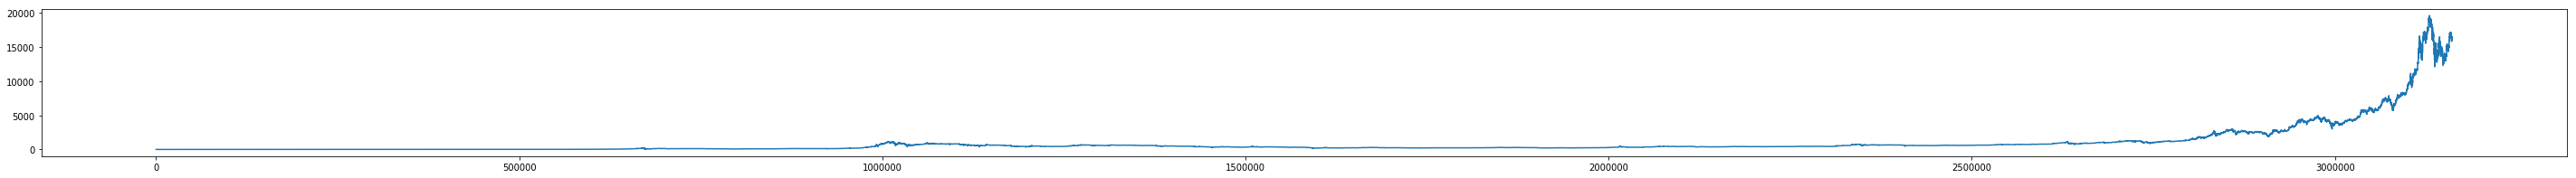

In [112]:
y = df.Close - df.Close.shift(1)
plt.rcParams['figure.figsize'] = (50, 3)
plt.plot(np.cumsum(y))

There is something strange with this plot

In [113]:
#We need to drop the last line as I shifted y
df = df.iloc[:-1]
y = y.iloc[1:]
print(y.shape)
print(df.shape)
y[y >= 0] = 1
y[y < 0] = -1
y.index = df.index

(105368,)
(105368, 10)


I've prepared y, next part will be calculating technical indicators:

CPU times: user 59.7 s, sys: 220 ms, total: 59.9 s
Wall time: 59.9 s


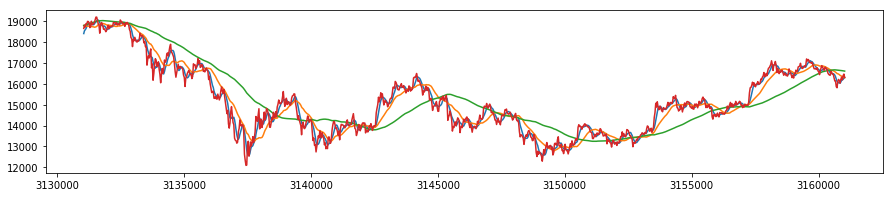

In [118]:
%%time
from pyti.simple_moving_average import simple_moving_average as sma
df['sma6'] = sma(df.Close, 6)
df['sma24'] = sma(df.Close, 24)
df['sma96'] = sma(df.Close, 96)
plt.rcParams['figure.figsize'] = (15, 3)
plt.plot(df.sma6[-1000:])
plt.plot(df.sma24[-1000:])
plt.plot(df.sma96[-1000:])
plt.plot(df.Close[-1000:])

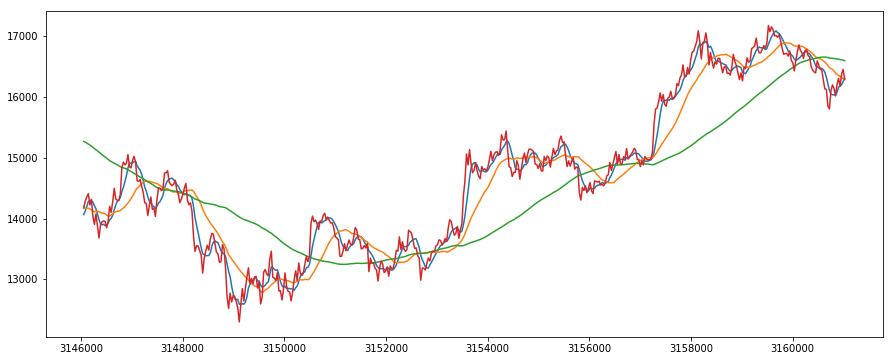

In [121]:
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(df.sma6[-500:])
plt.plot(df.sma24[-500:])
plt.plot(df.sma96[-500:])
plt.plot(df.Close[-500:])